# Learning Jammers: Loss Simulations
In this notebook, we will simulate different losses, compare their performance (BER) and have a look at their learned weights.

### Evaluation of different Losses

In [4]:
import os
# import drjit
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
# tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

In [5]:
# common parameters
model_parameters = {}
jammer_parameters = {}
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 1
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = 1.0
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model_parameters["num_silent_pilot_symbols"] = 4
jammer_parameters["trainable"] = True
model_parameters["jammer_parameters"] = jammer_parameters

In [6]:
# needed, as keras MSE does not take |.|
abs_mse = lambda y_true, y_pred: tf.reduce_mean(tf.square(tf.abs(y_true - y_pred)))
abs_log = lambda y_true, y_pred: tf.reduce_mean(tf.math.log(tf.abs(y_true - y_pred) + 1))
# name, loss_fn, over symbols?, loss_over_logits
parameters = [
    ("L1 over symbols", negative_function(MeanAbsoluteError()), True, False),
    ("MSE over symbols", negative_function(abs_mse), True, False),
    ("L1 over bit estimates", negative_function(MeanAbsoluteError()), False, False),
    ("MSE over bit estimates", negative_function(MeanSquaredError()), False, False),
    ("BCE over bit estimates (logits)", BinaryCrossentropy(from_logits=True), False, True),
    ("log over bit estimates", negative_function(abs_log), False, False),
]

In [ ]:

for name, loss_fn, over_symbols, loss_over_logits in parameters:
    model = Model(**model_parameters, return_symbols=over_symbols)
    train_model(model,
                loss_fn=loss_fn,
                loss_over_logits=loss_over_logits,
                weights_filename=f"weights/{name}.pickle",
                log_tensorboard=True,
                log_weight_images=True,
                show_final_weights=True)

In [24]:
sim.MAX_MC_ITER = 150
sim.BATCH_SIZE = 16
# exclude BCE, as it is too bad
parameters = [x for x in parameters if "BCE" not in x[0]]
model_parameters["return_symbols"] = False
jammer_parameters["trainable"] = False
for name, loss_fn, over_symbols, loss_over_logits in parameters:
    filename = f"weights/{name}.pickle"
    model = Model(**model_parameters)
    load_weights(model, filename)
    simulate_model(model, name)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.3970e-01 | 1.0000e+00 |     1325444 |     5529600 |         2400 |        2400 |        23.3 |reached max iter       
   -3.571 | 2.1265e-01 | 1.0000e+00 |     1175865 |     5529600 |         2400 |        2400 |        12.8 |reached max iter       
   -2.143 | 1.9090e-01 | 1.0000e+00 |     1055627 |     5529600 |         2400 |        2400 |        12.9 |reached max iter       
   -0.714 | 1.6976e-01 | 1.0000e+00 |      938702 |     5529600 |         2400 |        2400 |        13.1 |reached max iter       
    0.714 | 1.5829e-01 | 1.0000e+00 |      875259 |     5529600 |         2400 |        2400 |        12.8 |reached max iter       
    2.143 | 1.4566e-01 | 1.0000e+00 |      805420 |     5529600 |         2400 |     

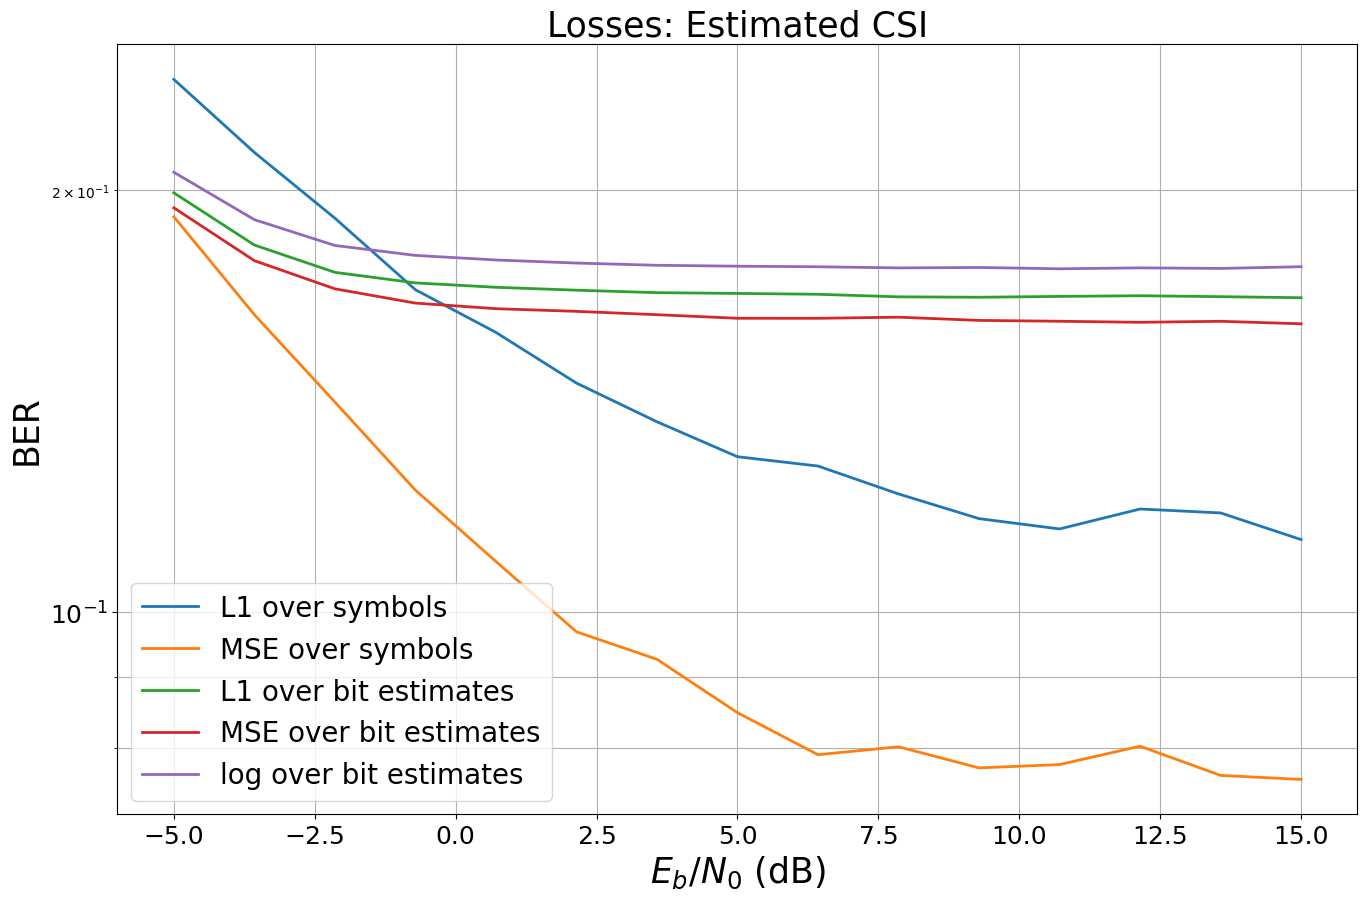

In [26]:
ber_plots.title = "Losses: Estimated CSI"
ber_plots()

### L1 Loss over Symbol Error, Different Constellation Sizes

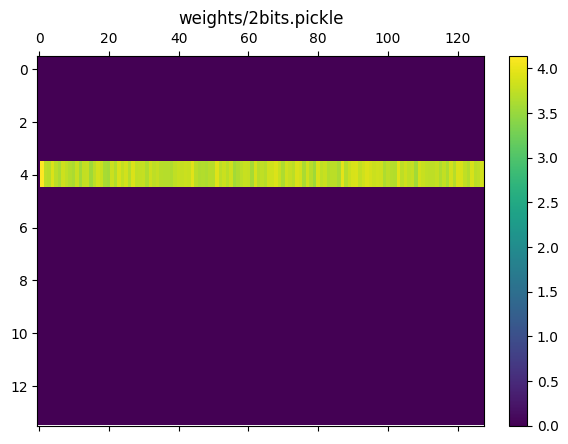

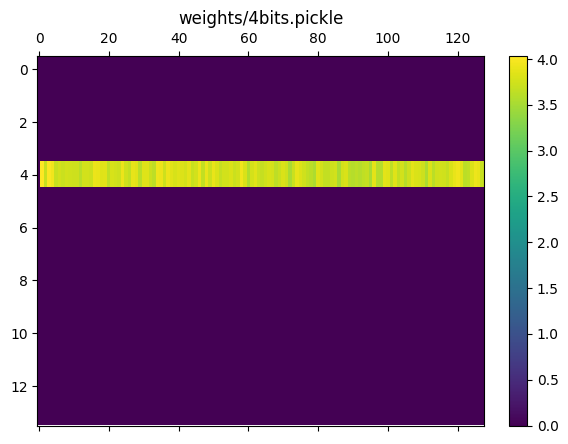

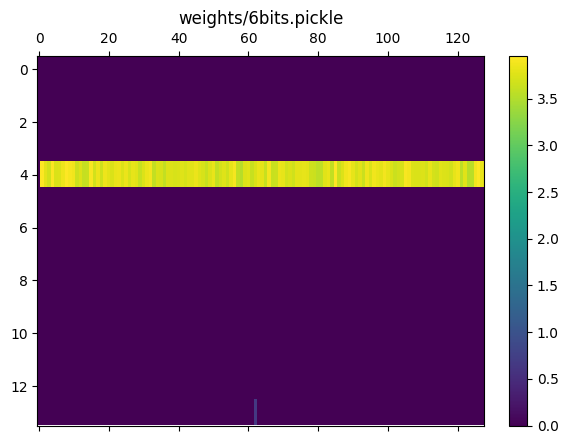

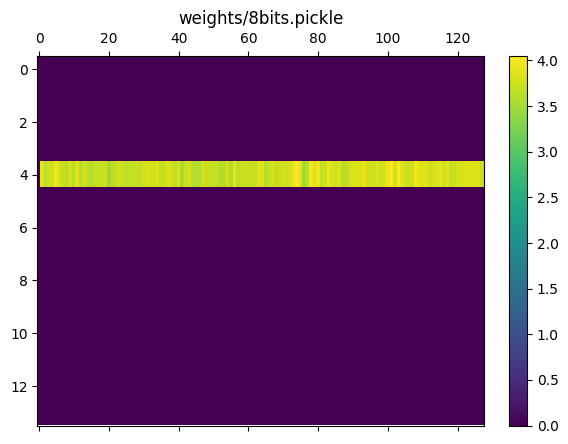

In [3]:
loss = negative_function(MeanAbsoluteError())
jammer_parameters["trainable"] = True
# 4, 16, 64, 256 - QAM
bits_per_symbol = [2, 4, 6, 8]
for b in bits_per_symbol:
    model = Model(**model_parameters, num_bits_per_symbol=b, return_symbols=True)
    train_model(model,
                loss_fn=loss,
                loss_over_logits=False,
                weights_filename=f"weights/{b}bits.pickle",
                log_tensorboard=True,
                log_weight_images=True,
                show_final_weights=True,
                num_iterations=2000)

### Training "log over bit estimates" on different SNRs

In [8]:
loss = negative_function(MeanAbsoluteError())
snrs = np.arange(-5, 10.5, 2.5)
jammer_parameters["trainable"] = True
for ebno_db in snrs:
    model = Model(**model_parameters)
    train_model(model,
                loss_fn=loss,
                loss_over_logits=False,
                weights_filename=f"weights/{ebno_db}db.pickle",
                log_tensorboard=True,
                log_weight_images=True,
                show_final_weights=True,
                num_iterations=2000,
                ebno_db=ebno_db)

TypeError: train_model() got an unexpected keyword argument 'ebno_db'

### Training over Symbol Time only (14 Parameters)

### Training over Non-silent Symbols only
To maybe prevent local maximum we are sliding into when learning to not jam silent symbols